<a href="https://colab.research.google.com/github/YounSooKimTech/Joy_NLP_Power/blob/main/src/Results_Left_on_read.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/YounSooKimTech/Joy_NLP_Power/main/data/Enron_merged_df.csv')
df.fillna('', inplace=True)


In [2]:
# example
print(len(df[(df["Sender_Email"] == "jeff.dasovich@enron.com") & (df["Receiver_Email"] == "christopher.calger@enron.com")]))

print(len(df[(df["Sender_Email"] == "christopher.calger@enron.com") & (df["Receiver_Email"] == "jeff.dasovich@enron.com")]))


14
5


In [3]:
unique_senders = df["Sender_Email"].unique().tolist()
unique_receivers = df["Receiver_Email"].unique().tolist()
email_list = list(set(unique_senders + unique_receivers))

count = 0
data = []
for a_mail in email_list:
    for b_mail in email_list:
        if a_mail != b_mail:
            # Count for a_mail as sender and b_mail as receiver
            df_filtered1 = df.loc[(df['Sender_Email'] == a_mail) & (df['Receiver_Email'] == b_mail)]
            freq1 = len(df_filtered1)

            # Count for b_mail as sender and a_mail as receiver
            df_filtered2 = df.loc[(df['Sender_Email'] == b_mail) & (df['Receiver_Email'] == a_mail)]
            freq2 = len(df_filtered2)

            if freq1 > 0 or freq2 > 0:
                data.append({'Sender': a_mail, 'Receiver': b_mail, 'a_mail to b_mail': freq1, 'b_mail to a_mail': freq2})

df_freq = pd.DataFrame(data)
df_freq

,Sender,Receiver,a_mail to b_mail,b_mail to a_mail
0,john.hodge@enron.com,frank.vickers@enron.com,0,1
1,john.hodge@enron.com,chris.germany@enron.com,0,2
2,john.hodge@enron.com,scott.neal@enron.com,0,1
3,susan.pereira@enron.com,chris.germany@enron.com,2,1
4,susan.pereira@enron.com,stacy.dickson@enron.com,2,1
...,...,...,...,...
767,john.zufferli@enron.com,john.lavorato@enron.com,0,2
768,john.zufferli@enron.com,david.delainey@enron.com,0,1
769,cooper.richey@enron.com,mike.grigsby@enron.com,0,1
770,cooper.richey@enron.com,jane.tholt@enron.com,1,1


In [4]:
df_freq[df_freq["Sender"] == "jeff.dasovich@enron.com"]

,Sender,Receiver,a_mail to b_mail,b_mail to a_mail
713,jeff.dasovich@enron.com,frank.vickers@enron.com,1,1
714,jeff.dasovich@enron.com,richard.sanders@enron.com,1,0
715,jeff.dasovich@enron.com,shelley.corman@enron.com,1,1
716,jeff.dasovich@enron.com,james.steffes@enron.com,61,26
717,jeff.dasovich@enron.com,kevin.hyatt@enron.com,1,0
718,jeff.dasovich@enron.com,lysa.akin@enron.com,8,7
719,jeff.dasovich@enron.com,chris.foster@enron.com,6,5
720,jeff.dasovich@enron.com,robert.badeer@enron.com,1,4
721,jeff.dasovich@enron.com,tim.belden@enron.com,7,2
722,jeff.dasovich@enron.com,keith.holst@enron.com,1,0


In [5]:
df_status = df[["Receiver_Email", "Sender_Email", "direction"]]
df_status= df_status.rename(columns={'direction': 'original_direction'})

df_status.head()

commu_freq = pd.merge(df_status, df_freq, left_on = ["Receiver_Email", "Sender_Email"], right_on = ["Sender", "Receiver"])
commu_freq = commu_freq.drop(["Receiver_Email", "Sender_Email"], axis=1)

In [6]:
print(commu_freq.groupby("original_direction")["a_mail to b_mail"].sum())

print(commu_freq.groupby("original_direction")["b_mail to a_mail"].sum())


original_direction
downward    4417
same        7140
upward      4417
Name: a_mail to b_mail, dtype: int64
original_direction
downward    6095
same        8907
upward      8648
Name: b_mail to a_mail, dtype: int64


In [7]:
# left on read operational definition

commu_freq["left_on_read"] = (commu_freq["a_mail to b_mail"] > commu_freq["b_mail to a_mail"]).astype(int)

commu_freq.groupby("original_direction")["left_on_read"].sum()

original_direction
downward    107
same        135
upward      139
Name: left_on_read, dtype: int64

In [8]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# fit an ANOVA model with the 'values' column as the dependent variable and the 'group' column as the independent variable
model = ols('left_on_read ~ C(original_direction)', data=commu_freq).fit()

# perform an ANOVA test
anova_table = sm.stats.anova_lm(model, typ=2)

# print the ANOVA table
print(anova_table)
print("\n\n")

# perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(commu_freq["left_on_read"], commu_freq['original_direction'])

# print the Tukey's HSD results
print(tukey_results)
print("\n\n")


                           sum_sq      df         F    PR(>F)
C(original_direction)    1.395903     2.0  4.301396  0.013685
Residual               301.644376  1859.0       NaN       NaN



 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
downward   same     0.06 0.0244  0.0062 0.1138   True
downward upward   0.0551 0.0397   0.002 0.1082   True
    same upward  -0.0048  0.976 -0.0589 0.0493  False
-----------------------------------------------------





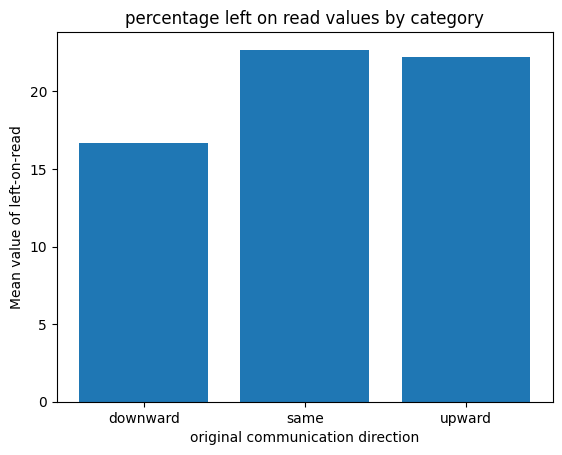

In [9]:
import matplotlib.pyplot as plt
means =commu_freq.groupby('original_direction')['left_on_read'].mean()*100
plt.bar(means.index, means.values)
plt.title('percentage left on read values by category')
plt.xlabel('original communication direction')
plt.ylabel('Mean value of left-on-read')
plt.show()